### Teixeira Scheme vs PySR equation in subtropics

In [4]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import json
import sys
import os
import gc

sys.path.insert(0, '/home/b/b309170/workspace_icon-ml/symbolic_regression')
from functions import append_dict_to_json
from sklearn import tree

sys.path.insert(0, os.environ['HOME'] + '/my_work/published_code/grundner23james_EquationDiscovery_CloudCover_addressing_reviews/sec2_data/')
import my_classes
from my_classes import load_data

subset_size = 10**8

np.random.seed(10)

**Read data**

In [5]:
# By coords sorts the time dimension correctly
clc = xr.open_mfdataset('/home/b/b309170/bd1179_work/DYAMOND/hvcg_data/clc/*', combine='by_coords')

# For relative humidity
pa = xr.open_mfdataset('/home/b/b309170/bd1179_work/DYAMOND/hvcg_data/pa/*', combine='by_coords')
ta = xr.open_mfdataset('/home/b/b309170/bd1179_work/DYAMOND/hvcg_data/ta/*', combine='by_coords')
hus = xr.open_mfdataset('/home/b/b309170/bd1179_work/DYAMOND/hvcg_data/hus/*', combine='by_coords')

T0 = 273.15
r = 0.00263*pa.pa*hus.hus*np.exp((17.67*(ta.ta-T0))/(ta.ta-29.65))**(-1) 

# Remaining input features
clw = xr.open_mfdataset('/home/b/b309170/bd1179_work/DYAMOND/hvcg_data/clw/*', combine='by_coords')
cli = xr.open_mfdataset('/home/b/b309170/bd1179_work/DYAMOND/hvcg_data/cli/*', combine='by_coords')

In [6]:
# Select only subtropical region (+- 23.43622 to +- 35)

# lon in [-pi, pi]
# lat in [-pi/2, pi/2]

def deg_to_rad(deg):
    return deg/90*np.pi/2

# Time, height, cell
r_subtrop = r.loc[:, :, np.where(((r.lat < deg_to_rad(35)) & (deg_to_rad(23.43622) < r.lat)) | ((r.lat > deg_to_rad(-35)) & (deg_to_rad(-23.43622) > r.lat)))[0]]
pa_subtrop = pa.pa.loc[:, :, np.where(((pa.lat < deg_to_rad(35)) & (deg_to_rad(23.43622) < pa.lat)) | ((pa.lat > deg_to_rad(-35)) & (deg_to_rad(-23.43622) > pa.lat)))[0]]
ta_subtrop = ta.ta.loc[:, :, np.where(((ta.lat < deg_to_rad(35)) & (deg_to_rad(23.43622) < ta.lat)) | ((ta.lat > deg_to_rad(-35)) & (deg_to_rad(-23.43622) > ta.lat)))[0]]
hus_subtrop = hus.hus.loc[:, :, np.where(((hus.lat < deg_to_rad(35)) & (deg_to_rad(23.43622) < hus.lat)) | ((hus.lat > deg_to_rad(-35)) & (deg_to_rad(-23.43622) > hus.lat)))[0]]
clw_subtrop = clw.clw.loc[:, :, np.where(((clw.lat < deg_to_rad(35)) & (deg_to_rad(23.43622) < clw.lat)) | ((clw.lat > deg_to_rad(-35)) & (deg_to_rad(-23.43622) > clw.lat)))[0]]
cli_subtrop = cli.cli.loc[:, :, np.where(((cli.lat < deg_to_rad(35)) & (deg_to_rad(23.43622) < cli.lat)) | ((cli.lat > deg_to_rad(-35)) & (deg_to_rad(-23.43622) > cli.lat)))[0]]
clc_subtrop = clc.clc.loc[:, :, np.where(((clc.lat < deg_to_rad(35)) & (deg_to_rad(23.43622) < clc.lat)) | ((clc.lat > deg_to_rad(-35)) & (deg_to_rad(-23.43622) > clc.lat)))[0]]

# # Sel and slice only works if we are doing it across a dimension not a coordinate of the array!!
# r.sel(cell = r.lat == slice(1,2))

(array([4355., 2990.,    0.,    0.,    0.,    0.,    0.,    0., 2990.,
        4355.]),
 array([-6.10516632e-01, -4.88413306e-01, -3.66309979e-01, -2.44206653e-01,
        -1.22103326e-01,  2.77555756e-15,  1.22103326e-01,  2.44206653e-01,
         3.66309979e-01,  4.88413306e-01,  6.10516632e-01]),
 <BarContainer object of 10 artists>)

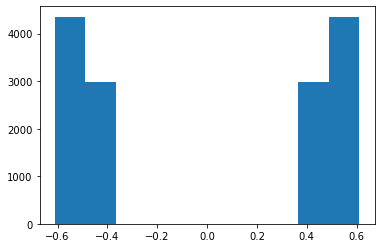

In [7]:
plt.hist(pa_subtrop.lat)

In [8]:
# Compute vertical derivative of relative humidity. Try forward Euler for simplicity.
zg = xr.open_mfdataset('/home/b/b309170/bd1179_work/DYAMOND/hvcg_data/zg/*', combine='by_coords')
zg_subtrop = zg.zg.loc[:, np.where(((zg.clat < deg_to_rad(35)) & (deg_to_rad(23.43622) < zg.clat)) | (zg.clat > deg_to_rad(-35)) & (deg_to_rad(-23.43622) > zg.clat))[0]]
zg_subtrop = np.repeat(np.expand_dims(zg_subtrop, axis=0), 619, axis=0)

r_subtrop_val = r_subtrop.values

dzrh_subtrop = (r_subtrop_val[:, 1:] - r_subtrop_val[:, :1])/(zg_subtrop[:, 1:] - zg_subtrop[:, :1])

In [9]:
# Reconcile vertical dimension
r_subtrop = r_subtrop[:, -30:]
pa_subtrop = pa_subtrop[:, -30:]
ta_subtrop = ta_subtrop[:, -30:]
hus_subtrop = hus_subtrop[:, -30:]
clw_subtrop = clw_subtrop[:, -30:]
cli_subtrop = cli_subtrop[:, -30:]
clc_subtrop = clc_subtrop[:, -30:]

In [10]:
# Scale clc to be in [0, 100]
clc_subtrop = 100*clc_subtrop

**Models**

In [11]:
# Teixeira scheme
def teixeira(clw, cli, ta, rh, pa):
    # Clausius-Clapeyron assuming a constant latent heat of vaporization and the ideal gas law (Lohmann, eq. 2.60)
    e0 = 611.2
    Lv = 2.5*10**6
    Rv = 461.5
    T0 = 273.15
    e = e0*np.exp(Lv/Rv*(1/T0-1/ta))
    
    # Tunable parameters
    (D, K) = (0.01, 0.0001002516165413534)

    # q_s (Saturation specific humidity): The specific humidity of water vapor corresponding to the saturation mixing ratio
    # Assuming the water pressure to be much smaller than the atmospheric pressure (Lohmann, eq. 2.80)
    eps = 0.622
    qs = eps*e/pa

    # Small threshold to avoid division by zero
    thr = 1e-9
    c = D*clw/(2*qs*(1-np.minimum(rh, 1-thr))*K)*(np.sqrt(np.maximum(0, 1 + (4*qs*(1-np.minimum(rh, 1-thr))*K)/(D*np.maximum(clw, thr)))) - 1)

    # c can exceed 1 very slightly
    c = np.minimum(c, 1)
    
    return np.minimum(np.maximum(100*c, 0), 100)

In [12]:
# PySR equation
def pysr(clw, cli, ta, rh, rh_z):
    # (a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,a_10,a_11,eps,A,B) = (2.44602578e+02, 6.50754419e-02, 3.87865894e-02, 3.38579968e+01, 4.21678865e+03, 1.87848876e+01, 2.19807008e+03, 1.34231436e+05, 3.11805366e-03, 1.51425129e+00, 5.48080889e+00, 1.70666033e-06, 1.04823218e+00, 1.57514190e-04)
    (a_1,a_2,a_3,a_4,a_5,a_6,a_7,a_8,a_9,a_10,a_11,eps,A,B) = (203, 0.06588, 0.03969, 33.87, 4224.6, 18.9586, 2202.6, 20000000000, 60000000, 8641, 32544, 0.0106, 1, 1)
    
    # Modified to always satisfy RH-constraint
    rh = np.maximum(rh, -a_2/(2*a_1)*ta**2 + a_4/(2*a_1)*ta - a_5/(2*a_1))
    
    I1 = a_1*rh**2+ta**2*(a_2*rh-a_3)-a_4*rh*ta+a_5*rh+a_6*ta-a_7
    I2 = (rh_z)**2*(a_8*rh_z+a_9) 
    I3 = -B/(a_10*clw+a_11*cli+eps)
    
    clc = np.minimum(np.maximum(I1 + I2 + I3, 0), 100) 
    clc_val = clc.values
    
    # 0 in the condensate-free regime
    cond_free_inds = np.where(clw + cli < 1e-12)
    clc_val[cond_free_inds] = 0
    
    return clc_val

**Evaluation**

In [29]:
# Compute MSEs on subtropical region alone

# Predict
teixeira_pred = teixeira(clw_subtrop, cli_subtrop, ta_subtrop, r_subtrop, pa_subtrop)
pysr_pred = pysr(clw_subtrop, cli_subtrop, ta_subtrop, r_subtrop, dzrh_subtrop)

# Cast to numpy
teixeira_pred_val = teixeira_pred.values
clc_subtrop_val = clc_subtrop.values

# Compute means (ignore nans)
teixeira_mse = np.nanmean((teixeira_pred_val - clc_subtrop_val)**2)
pysr_mse = np.nanmean((pysr_pred - clc_subtrop_val)**2)

# Print results
print('Teixeira MSE: %.3f'%(teixeira_mse))
print('PySR MSE: %.3f'%(pysr_mse))

Teixeira MSE: 290.294
PySR MSE: 115.492


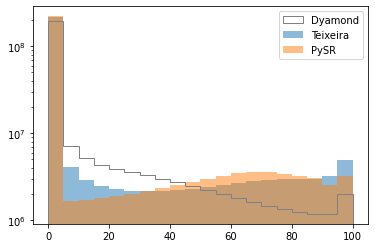

In [28]:
# Checking cloud cover distributions
plt.hist(np.reshape(teixeira_pred_val, -1), bins=20, alpha=.5)
plt.hist(np.reshape(pysr_pred, -1), bins=20, alpha=.5)
plt.hist(np.reshape(clc_subtrop_val, -1), bins=20, histtype='step', color='gray')
plt.yscale('log')

plt.legend(['Dyamond', 'Teixeira', 'PySR'])